In [1]:
#  Install Java & Spark (needed only once per runtime)
!apt-get install openjdk-11-jdk -qq > /dev/null
!pip install pyspark==3.5.1 -q

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

spark = SparkSession.builder.getOrCreate()

# Schema
schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", IntegerType())
])

# Inline data
data = [
    ("O001", "South", "Electronics", 3, 15000),
    ("O002", "North", "Clothing", 5, 2000),
    ("O003", "East", "Furniture", 2, 12000),
    ("O004", "West", "Electronics", 1, 18000),
    ("O005", "North", "Furniture", 4, 9000),
    ("O006", "South", "Clothing", 6, 2500),
    ("O007", "East", "Electronics", 2, 17000)
]

# Create Dataframe
df = spark.createDataFrame(data, schema)

# Show Dataframe
df.show()

+--------+------+-----------+--------+-----+
|order_id|region|   category|quantity|price|
+--------+------+-----------+--------+-----+
|    O001| South|Electronics|       3|15000|
|    O002| North|   Clothing|       5| 2000|
|    O003|  East|  Furniture|       2|12000|
|    O004|  West|Electronics|       1|18000|
|    O005| North|  Furniture|       4| 9000|
|    O006| South|   Clothing|       6| 2500|
|    O007|  East|Electronics|       2|17000|
+--------+------+-----------+--------+-----+



In [5]:
from pyspark.sql.functions import col, sum as _sum, avg, count

# Total revenue column
df = df.withColumn("revenue", col("quantity") * col("price"))

# Summary by category
category_summary = df.groupBy("category").agg(
    _sum("revenue").alias("total_quantity"),
    _sum("revenue").alias("total_revenue"),
    avg("revenue").alias("avg_order_value")
)

# Show summary
category_summary.show()

# Summary by region
region_summary = df.groupBy("region").agg(
    count("*").alias("total_orders"),
    _sum("revenue").alias("total_revenue")
)

# Show summary
region_summary.show()

+-----------+--------------+-------------+------------------+
|   category|total_quantity|total_revenue|   avg_order_value|
+-----------+--------------+-------------+------------------+
|Electronics|         97000|        97000|32333.333333333332|
|   Clothing|         25000|        25000|           12500.0|
|  Furniture|         60000|        60000|           30000.0|
+-----------+--------------+-------------+------------------+

+------+------------+-------------+
|region|total_orders|total_revenue|
+------+------------+-------------+
| South|           2|        60000|
|  East|           2|        58000|
| North|           2|        46000|
|  West|           1|        18000|
+------+------------+-------------+



In [6]:
# Change chart type in Databricks UI
display(category_summary)

# Try Pie Chart for total revenue by region
display(region_summary)

DataFrame[category: string, total_quantity: bigint, total_revenue: bigint, avg_order_value: double]

DataFrame[region: string, total_orders: bigint, total_revenue: bigint]

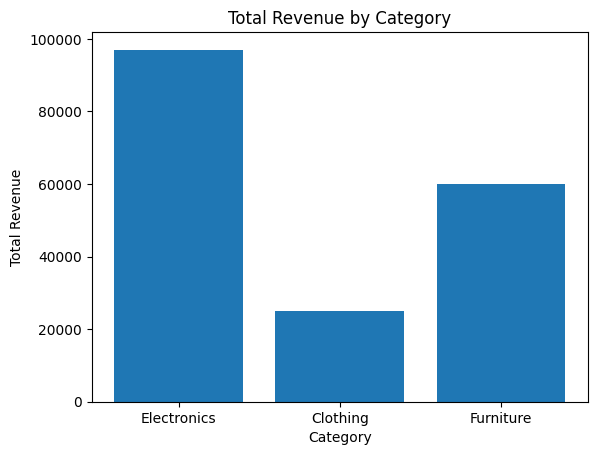

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for matplotlib
pdf = category_summary.toPandas()

plt.bar(pdf['category'], pdf['total_revenue'])
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Category')
plt.show()

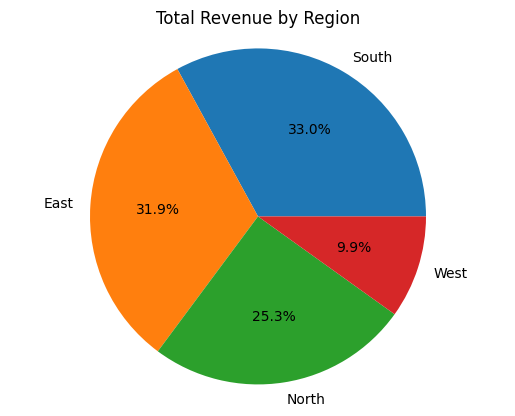

In [12]:
# Built a piechart for the same data
pdf = region_summary.toPandas()

plt.pie(pdf['total_revenue'], labels=pdf['region'], autopct='%1.1f%%')
plt.title('Total Revenue by Region')
plt.axis('equal')
plt.show()

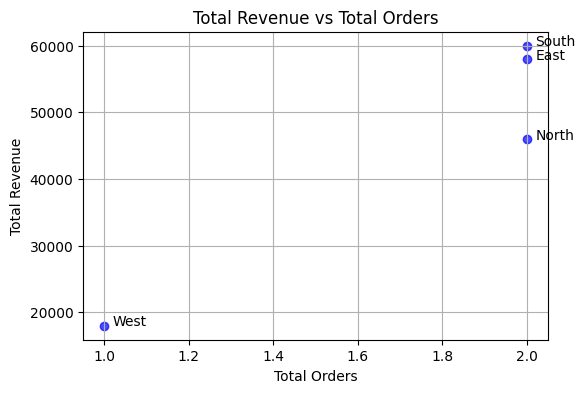

In [17]:
# Create the scatter plot for the same data
pdf_region = region_summary.toPandas()

plt.figure(figsize=(6,4))
plt.scatter(pdf_region['total_orders'], pdf_region['total_revenue'], color='blue', alpha=0.7)

# Add region labels
for i, row in pdf_region.iterrows():
    plt.text(row['total_orders']+0.02, row['total_revenue'], row['region'])

plt.xlabel('Total Orders')
plt.ylabel('Total Revenue')
plt.title('Total Revenue vs Total Orders')
plt.grid(True)
plt.show()